In [252]:
from simpledbf import Dbf5
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta

In [253]:
'''
comorbidades para serem convertidas em uma variavel
variaveis sensiveis com relação a vacinação segundo o ministerio da saude
'''
comorbidades = ["PNEUMOPATI", "CARDIOPATI", "IMUNODEPRE", "HEPATICA", "NEUROLOGIC", "RENAL", "SIND_DOWN", "PUERPERA", "OBESIDADE", ] #, "METABOLICA"
sensitive_vars = ["CS_SEXO", "NU_IDADE_N", "SG_UF_NOT", "VACINA", "EVOLUCAO", "DT_NASC", "DT_NOTIFIC"] # "ID_MUNICIP", != ID_REGIONA |  , "DT_NASC", "DT_NOTIFIC"

In [254]:
'''
carrega todas as versões do DF
'''
def load_dataframes():
    dataframes = []
    for i in range(9,19):
        numer = f'INFLU{"0" + str(i) if i < 10 else i}S.DBF'
        dataframes.append(Dbf5(numer, codec='latin-1').to_dataframe())
    dataframes.append(pd.read_excel("BD SRAGHOSP 2019 SE 05.xlsx"))
    return dataframes

In [255]:
def clean_db_sensitive_infodf(df):
    clean_dataframes = []
    clean_fields = sensitive_vars
    clean_dataframe = df[clean_fields].replace(np.nan, 9, regex=True)
    clean_fields = sensitive_vars + comorbidades
    clean_dataframe = df[clean_fields].replace(np.nan, 0, regex=True)[df["VACINA"]!=9]
    return clean_dataframe
        

In [256]:
def transform_comorbidades(df):
    df_comorbidades = df[comorbidades]
    df_comorbidades_flat = df_comorbidades.applymap(lambda x: '1' if int(x) == 2 else '0')
    df_comorbidades_flat_comorbidades = df_comorbidades_flat.sum(axis=1).astype(int).astype(str)
    df_result = df.loc[:,(sensitive_vars)]
    df_result['COMORBIDADES'] = df_comorbidades_flat_comorbidades.map(lambda x: bytes_string_to_int(x))
    #df_result['COMORBIDADES'] = pd.get_dummies(df_comorbidades_flat)
    return df_result


In [257]:
def transform_comorbidades_raw(df):
    df_comorbidades = df[comorbidades]
    df_comorbidades_flat = df_comorbidades.applymap(lambda x: '1' if int(x) == 2 else '0')
    df_comorbidades_flat_comorbidades = df_comorbidades_flat.sum(axis=1).astype(int).astype(str)
    df_result = df.loc[:,(sensitive_vars)]
    df['COMORBIDADES'] = df_comorbidades_flat_comorbidades.map(lambda x: bytes_string_to_int(x))
    return df

In [258]:
def convert_date(date):
    if (date[0] == '4'):
        return int(float(date)) - 4000
    else:
        return 1
    

In [259]:
def convert_uf(uf):
    if uf == "RO":
        return 11
    elif uf == "AC":
        return 12
    elif uf == "AM":
        return 13
    elif uf == "RR":
        return 14
    elif uf == "PA":
        return 15
    elif uf == "AP":
        return 16
    elif uf == "TO":
        return 17
    elif uf == "MA":
        return 21
    elif uf == "PI":
        return 22
    elif uf == "CE":
        return 23
    elif uf == "RN":
        return 24
    elif uf == "PB":
        return 25
    elif uf == "PE":
        return 26
    elif uf == "AL":
        return 27
    elif uf == "SE":
        return 28
    elif uf == "BA":
        return 29
    elif uf == "MG":
        return 31
    elif uf == "ES":
        return 32
    elif uf == "RJ":
        return 33
    elif uf == "SP":
        return 35
    elif uf == "PR":
        return 41
    elif uf == "SC":
        return 42
    elif uf == "RS":
        return 43
    elif uf == "MS":
        return 50
    elif uf == "MT":
        return 51
    elif uf == "GO":
        return 52
    elif uf == "DF":
        return 53
    else:
        return int(uf)



In [260]:
def convert_fields(df):
    df = df[(df['VACINA'].map(lambda x: int(x)) != 9.0)].copy()
    df['IDADE'] = (pd.to_datetime(df['DT_NOTIFIC'], errors = 'coerce') - pd.to_datetime(df['DT_NASC'], errors = 'coerce')) / timedelta(days=365)
    df['CS_SEXO'] = df['CS_SEXO'].map(lambda x: 1 if x == "F" else 2)
    df['VACINA'] = df['VACINA'].map(lambda x: 1 if x == "2" or x == 2.0 else 0)
    df['SG_UF_NOT'] = df['SG_UF_NOT'].map(lambda x: convert_uf(x))
    df['EVOLUCAO'] = df['EVOLUCAO'].map(lambda x: 1 if x == "2" or x == "4" or x == 2.0 or x == 4.0 else 0)
    return df

In [358]:
label_dict = {
    "CS_SEXO": {
        1: "Feminino",
        2: "Masculino"
    },
    "VACINA": {
        1: "Sim",
        0: "Não"
    }
}

for i in comorbidades:
    label_dict[i] = {
        '1': "Sim",
        '2': "Não",
        1: "Sim",
        2: "Não" #FIX: BETTER DATA CLEANUP PROCESS
    }
        

In [261]:
def bytes_string_to_int(x):
    total_sum = 0
    for i in range(len(x)):
        total_sum = total_sum + (int(x[i]) << i)
    return total_sum
        

In [262]:
def format_heatmap(corr, figname="Name.png"):
    
    sns.set_theme(style="white")
    
    
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    plot = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
                square=True, linewidths=.3, cbar_kws={"shrink": .5}, vmax=1, vmin=-1)
    f.savefig(figname)
    

In [263]:
#DEPRECATED
def format_heatmap_mask_evolucao(corr, figname="Name.png"):
    
    sns.set_theme(style="white")
    
    
    mask = [
        [0,0,0,1],
        [1,1,1,1],
    ]

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    plot = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
                square=True, linewidths=.1, cbar_kws={"shrink": .1})
    f.savefig(figname)

In [264]:
def extract_region(df):
    regions_df = []
    regions = [["53","52","50","51"],["16","12","13","15","11","14","17"],["27","29","23","21","25","22","26","24","28"],["32","31","33","35"],["43","42","41"]]
    for i in regions:
        regions_df.append(df[df["SG_UF_NOT"].isin(i)])
    return regions_df

In [265]:
def clean_processed(df):
    return df[["CS_SEXO", "VACINA", "COMORBIDADES"]]

In [266]:
def extract_dates(df):
    df_ages = {}
    old_i = 0
    for i in range(1,9):
        df_ages[f"{i*10}"] = clean_processed(df[(df["IDADE"] <= i*10) & (df["IDADE"] > old_i*10)])
        old_i = i
    df_ages[f"80+"] = clean_processed(df[(df["IDADE"] > old_i*10)])
    return df_ages

In [267]:
def clean_df(df):
    pipeline = [clean_db_sensitive_infodf, transform_comorbidades, convert_fields]
    clean_df = df
    for i in pipeline:
        clean_df = i(clean_df)
    return clean_df

In [268]:
def clean_df_non_trannsform_comorbidades(df):
    pipeline = [clean_db_sensitive_infodf, convert_fields]
    clean_df = df
    for i in pipeline:
        clean_df = i(clean_df)
    return clean_df

In [269]:
def generate_regions(df):

    output = {}

    data = 9

    for i in df:

        extracted_region = extract_region(clean_df(i))
        output[f"20{'0' + str(data) if data < 10 else data}"] = { 
            "centro-oeste": extract_dates(extracted_region[0]),
            "norte": extract_dates(extracted_region[1]),
            "nordeste": extract_dates(extracted_region[2]),
            "sudeste": extract_dates(extracted_region[3]),
            "sul": extract_dates(extracted_region[4]),
        }
        data+= 1
    return output
        

In [270]:
def add_obitos_to_df(df, obitos=0):
    if obitos == 0:
        return df[(df["EVOLUCAO"] == 1)]
    elif obitos == 1:
        return df[(df["EVOLUCAO"] == 0)]
    else:
        return df
    #df[(df["EVOLUCAO"] == 0)]
    #df["OBITOS"] = df.sum()["EVOLUCAO"]
    

In [271]:
clean_output_obitos = ["CS_SEXO", "VACINA", "COMORBIDADES", "EVOLUCAO"]

def pipe_obitos_correlation(dfs, obitos=0):
    output = {}
    data = 9
    for i in dfs:
        clean_df_result = clean_df(i)
        extracted_region = extract_region(clean_df_result[(clean_df_result["IDADE"] <= 60)])
        output[f"20{'0' + str(data) if data < 10 else data}"] = { 
            "centro-oeste": add_obitos_to_df(extracted_region[0],obitos)[clean_output_obitos],
            "norte": add_obitos_to_df(extracted_region[1],obitos)[clean_output_obitos],
            "nordeste": add_obitos_to_df(extracted_region[2],obitos)[clean_output_obitos],
            "sudeste": add_obitos_to_df(extracted_region[3],obitos)[clean_output_obitos],
            "sul": add_obitos_to_df(extracted_region[4],obitos)[clean_output_obitos],
        }
        data+= 1
    output_mais_60 = {}
    data = 9
    for i in dfs:
        clean_df_result = clean_df(i)
        extracted_region = extract_region(clean_df_result[(clean_df_result["IDADE"] > 60)])
        output_mais_60[f"20{'0' + str(data) if data < 10 else data}"] = { 
            "centro-oeste": add_obitos_to_df(extracted_region[0],obitos)[clean_output_obitos],
            "norte": add_obitos_to_df(extracted_region[1],obitos)[clean_output_obitos],
            "nordeste": add_obitos_to_df(extracted_region[2],obitos)[clean_output_obitos],
            "sudeste": add_obitos_to_df(extracted_region[3],obitos)[clean_output_obitos],
            "sul": add_obitos_to_df(extracted_region[4],obitos)[clean_output_obitos],
        }
        data+= 1
    return output, output_mais_60

In [294]:

def pipe_obitos_correlation_non_transofrm(dfs, obitos=0):
    clean_output_obitos_full = ["CS_SEXO", "VACINA", "EVOLUCAO"]
    clean_output_obitos_full += comorbidades

    output = {}
    data = 9
    for i in dfs:
        clean_df_result = clean_df_non_trannsform_comorbidades(i)
        extracted_region = extract_region(clean_df_result[(clean_df_result["IDADE"] <= 60)])
        output[f"20{'0' + str(data) if data < 10 else data}"] = { 
            "centro-oeste": add_obitos_to_df(extracted_region[0],obitos)[clean_output_obitos_full],
            "norte": add_obitos_to_df(extracted_region[1],obitos)[clean_output_obitos_full],
            "nordeste": add_obitos_to_df(extracted_region[2],obitos)[clean_output_obitos_full],
            "sudeste": add_obitos_to_df(extracted_region[3],obitos)[clean_output_obitos_full],
            "sul": add_obitos_to_df(extracted_region[4],obitos)[clean_output_obitos_full],
        }
        data+= 1
    output_mais_60 = {}
    data = 9
    for i in dfs:
        clean_df_result = clean_df_non_trannsform_comorbidades(i)
        extracted_region = extract_region(clean_df_result[(clean_df_result["IDADE"] > 60)])
        output_mais_60[f"20{'0' + str(data) if data < 10 else data}"] = { 
            "centro-oeste": add_obitos_to_df(extracted_region[0],obitos)[clean_output_obitos_full],
            "norte": add_obitos_to_df(extracted_region[1],obitos)[clean_output_obitos_full],
            "nordeste": add_obitos_to_df(extracted_region[2],obitos)[clean_output_obitos_full],
            "sudeste": add_obitos_to_df(extracted_region[3],obitos)[clean_output_obitos_full],
            "sul": add_obitos_to_df(extracted_region[4],obitos)[clean_output_obitos_full],
        }
        data+= 1
    return output, output_mais_60

In [273]:
def format_all_graphs(df, sufix = "/out/menos60"):
    output = {}
    for i in df.keys():
        output[i] = []
        ii = df[i]
        for j in ii.keys():
            k = ii[j]
            #format_heatmap_mask_evolucao(, f"{sufix}/{i}/{j}.png")
            output[i].append(k.corr()["EVOLUCAO"].iloc[:3])
    return output
        

In [274]:
def format_heatmap_with_legends(corr, y, x, figname="Name.png"):
    
    sns.set_theme(style="white")
    
    
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    plot = sns.heatmap(corr, cmap=cmap, center=0, annot=True,
                    square=True, vmin=-1, vmax=1, yticklabels=y, 
                    xticklabels=x)
    f.savefig(figname)

In [275]:
'''
pega os dados da funcao generate_regions e formata para graficos de correlação e os salva
save_corr_graphs(outp)

'''
def save_corr_graphs(opt):
    for i in opt.keys():
        v = opt[i]
        for j in v.keys():
            u = v[j]
            for k in u.keys():
                w = u[k].corr()
                format_heatmap(opt[i][j][k].corr(), f"./out/corr/{i}-{j}-{k}.png")
                
#format_heatmap(outp['2010']['nordeste']['80'].corr(), "./out/corr")

In [276]:
def each_individual_matrix(data, current_id):

    
    resultmatrix = format_all_graphs(data, current_id)
    
    for i in resultmatrix.keys():
        transposed_matrixx = np.array(resultmatrix[i])
        format_heatmap_with_legends(transposed_matrixx, out_per_region_mais_60['2010'].keys(), out_per_region_mais_60['2010']['nordeste'].keys()[:3], f"{i}.png")

In [277]:
def format_heatmap_with_legends_no_pre_fig(f, corr, y, x, figname="Name.png"):
    
    sns.set_theme(style="white")
    
    
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    plot = sns.heatmap(corr, cmap=cmap, center=0, annot=True,
                    square=True, vmin=-1, vmax=1, yticklabels=y, 
                    xticklabels=x)
    f.savefig(figname)

In [278]:
def global_matrix(data, current_id, aa="None"):

    
    resultmatrix = format_all_graphs(data, current_id)
    
    #centro_oeste = []
    #norte = []
    #nordeste = []
    #sudeste = []
    #sul = []
    xlabel = []
    sns.set_theme(style="white")
    sns.set(font_scale=0.8)
    
    f, asx = plt.subplots(1,11, figsize=(15,15))
    f.subplots_adjust(0,0,1,1,0.06,0)

    
    iio = 0
    
    for i in resultmatrix.keys():
        
        transposed_matrixx = np.array(resultmatrix[i])
        #centro_oeste += list(transposed_matrixx[0])
        #norte += list(transposed_matrixx[1])
        #nordeste += list(transposed_matrixx[2])
        #sudeste += list(transposed_matrixx[3])
        #sul += list(transposed_matrixx[4])
        #xlabel += list(out_per_region_mais_60['2010']['nordeste'].keys()[:3])
        
        
        

        # Set up the matplotlib figure
        

        asx[iio].title.set_text(i)

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        bar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.05)
        

        # Draw the heatmap with the mask and correct aspect ratio
        plot = sns.heatmap(transposed_matrixx, ax=asx[iio], square=True, cbar=False if iio != 12 else True, cbar_kws=bar_kws,
                          xticklabels=out_per_region_mais_60['2010']['nordeste'].keys()[:3], yticklabels=out_per_region_mais_60['2010'].keys(),
                          cmap=cmap, center=0, annot=True, vmin=-1, vmax=1)

        if iio == 0:
            asx[iio].set_ylabel("COMORBIDADES")
        else:
            asx[iio].set_yticklabels([], rotation = 90)
            
        if iio == 5:
            asx[iio].set_xlabel("variaveis")


        #plot.legend(loc=2, prop={'size': 6})
   
        #format_heatmap_with_legends(output, , , )

            #sns.heatmap(, center=0, annot=True,
            #                square=True, vmin=-1, vmax=1, yticklabels=, 
            #                xticklabels=)
        iio+=1

    f.savefig(f"{current_id}/fig-global-{aa}.png")
    
    
    
#global_matrix(out_per_region_mais_60, "./out/mais60", "mais que 60")

In [279]:
def global_matrix_old(data, current_id, aa="None"):

    
    resultmatrix = format_all_graphs(data, current_id)
    
    centro_oeste = []
    norte = []
    nordeste = []
    sudeste = []
    sul = []
    xlabel = []
    
    for i in resultmatrix.keys():
        
        transposed_matrixx = np.array(resultmatrix[i])
        centro_oeste += list(transposed_matrixx[0])
        norte += list(transposed_matrixx[1])
        nordeste += list(transposed_matrixx[2])
        sudeste += list(transposed_matrixx[3])
        sul += list(transposed_matrixx[4])
        xlabel += list(out_per_region_mais_60['2010']['nordeste'].keys()[:3])
        
    output = [centro_oeste, norte, nordeste, sudeste, sul]
    
    sns.set(font_scale=20)
    
    sns.set_theme(style="white")

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30, 30))
    
    ax.title.set_text(aa)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    plot = sns.heatmap(output, cmap=cmap, center=0, annot=True,
                    square=True, vmin=-1, vmax=1, yticklabels=out_per_region_mais_60['2010'].keys(), 
                    xticklabels=xlabel)
    
    
    
    #plot.legend(loc=2, prop={'size': 6})
    f.savefig(f"{current_id}/fig-global-{aa}.png")
    #format_heatmap_with_legends(output, , , )

        #sns.heatmap(, center=0, annot=True,
        #                square=True, vmin=-1, vmax=1, yticklabels=, 
        #                xticklabels=)

In [280]:
def plot_pie_graph_regions(df, variable='CS_SEXO', labels=('Feminino', 'Masculino'), title="No title"):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    fig1, ((a11,a12,a13), (a21,a22,a23)) = plt.subplots(2,3, figsize=(15,15))
    
    avaliable_plots = [a11, a12, a13, a21, a22, a23]
    
    
    explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    
    plot = 0
    
    for i in df.keys():
        
        sizes = list(df[i][variable].value_counts())
        avaliable_plots[plot].title.set_text(i)
        if len(sizes)==1:
            label = [labels[0]] if 1 in df[i][variable].value_counts().keys() else [labels[1]]
            avaliable_plots[plot].pie(sizes, labels=label, autopct='%1.1f%%',
                shadow=True, startangle=90)
        elif len(sizes)==2:
            avaliable_plots[plot].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        
        avaliable_plots[plot].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plot+= 1
    fig1.suptitle(title, fontsize=16)

In [281]:
def plot_histogram_regions_em(df, variable='CS_SEXO', labels=('Feminino', 'Masculino')):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    fig1, ((a11,a12,a13), (a21,a22,a23)) = plt.subplots(2,3, figsize=(15,15))
    
    avaliable_plots = [a11, a12, a13, a21, a22, a23]
    
    
    explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    
    plot = 0
    
    for i in df.keys():
        
        sizes = list(df[i][variable].value_counts())
        avaliable_plots[plot].title.set_text(i)
        if len(sizes)==1:
            label = [labels[0]] if 1 in df[i][variable].value_counts().keys() else [labels[1]]
            avaliable_plots[plot].pie(sizes, labels=label, autopct='%1.1f%%',
                shadow=True, startangle=90)
        elif len(sizes)==2:
            avaliable_plots[plot].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        
        avaliable_plots[plot].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plot+= 1

In [282]:
def plot_histogram_regions(df, variable='COMORBIDADES', title="None"):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    fig1, ((a11,a12,a13), (a21,a22,a23)) = plt.subplots(2,3, figsize=(15,15))
    
    avaliable_plots = [a11, a12, a13, a21, a22, a23]
    
    
    explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    
    plot = 0
    
    for i in df.keys():
        
        sizes = list(df[i][variable])
        avaliable_plots[plot].title.set_text(i)
        avaliable_plots[plot].hist(sizes, range=(0,500), histtype="stepfilled")
        
        avaliable_plots[plot].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plot+= 1
    fig1.suptitle(title, fontsize=16)

In [283]:
def extract_important_commobities(comobities_list):
    output = [int(x) for x in '{:08b}'.format(comobities_list)]
    opt = []
    ii = 0
    for i in output:
        opt.append(comorbidades[ii] if i else "")
        ii+=1
    return " ".join(opt)

In [284]:
#format_heatmap()

## Carregar todos os dados

In [111]:
dataframes_org = load_dataframes()

In [41]:
#aa = dataframes_org[-1][['NU_IDADE_N', 'DT_NASC', 'DT_NOTIFIC', 'EVOLUCAO', 'VACINA']]
#pd.get_dummies(dataframes_org[-1][comorbidades].dropna())
#aag = (pd.to_datetime(aa['DT_NOTIFIC']) - pd.to_datetime(aa['DT_NASC']))/ timedelta(days=365)
#print([comorbidades + ["COMORBIDADES"]])
#transform_comorbidades_raw(dataframes_org[3].replace(np.nan, 0, regex=True))[comorbidades + ["COMORBIDADES"]]

#clean_fields = sensitive_vars + comorbidades
    #clean_dataframe = df[clean_fields].replace(np.nan, 9, regex=True)

,PNEUMOPATI,CARDIOPATI,IMUNODEPRE,HEPATICA,NEUROLOGIC,RENAL,SIND_DOWN,PUERPERA,OBESIDADE
28,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
41,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0
47,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
60,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...
48223,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,9.0
48230,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
48234,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
48238,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0


## Limpar dados

In [301]:
outp = generate_regions(dataframes_org)
out_per_region, out_per_region_mais_60 = pipe_obitos_correlation(dataframes_org, 2)
global_correlation_variables = {
    'menos_60': out_per_region,
    'mais_60': out_per_region_mais_60
}

In [323]:
out_per_region_dead, out_per_region_mais_60_dead = pipe_obitos_correlation_non_transofrm(dataframes_org, 0)
out_per_region_infect, out_per_region_mais_60_infect = pipe_obitos_correlation_non_transofrm(dataframes_org, 1)
output_celan = {
    "mortos": {
        'menos_60': out_per_region_dead,
        'mais_60': out_per_region_mais_60_dead
    },
    "infectados": {
        'menos_60': out_per_region_infect,
        'mais_60': out_per_region_mais_60_infect
    }
}

## Estudo relação de variaveis

In [35]:
#save_corr_graphs(outp)

## Heatmap (Estudo de Obitos)

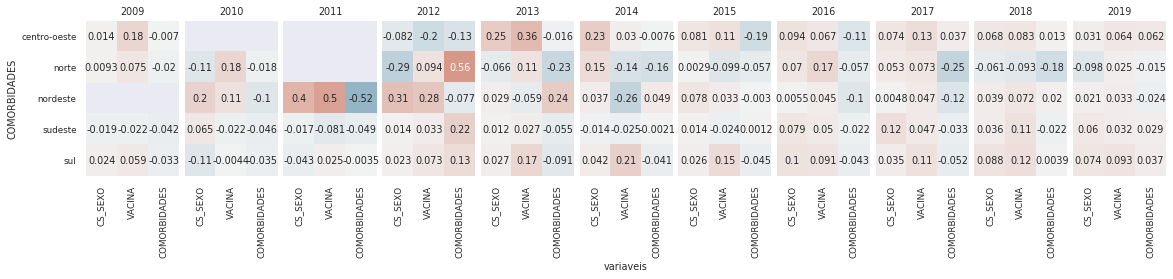

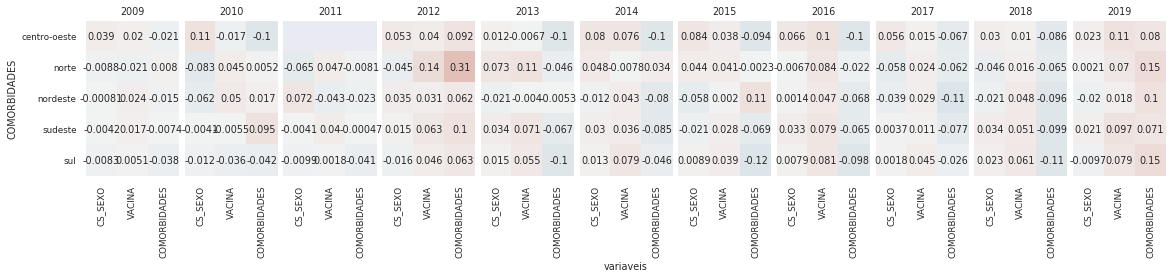

In [302]:
global_matrix(global_correlation_variables['mais_60'], "./out/mais60", "mais que 60")
global_matrix(global_correlation_variables['menos_60'], "./out/menos60", "menos que 60")


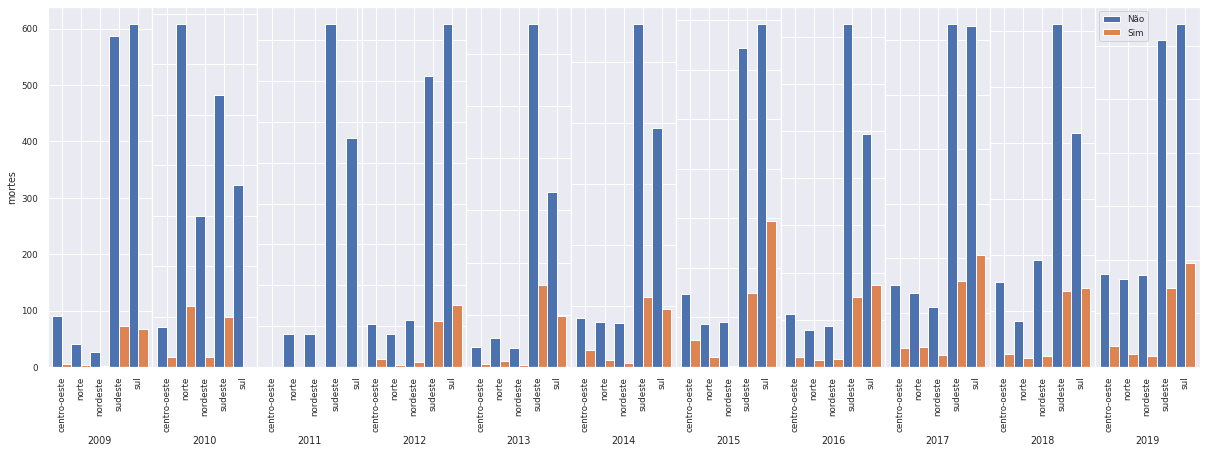

In [385]:













'''      GRAFICOS DE linha  (global/linha)  (barra/por regiao)
entrega semana (26/04)



p cada um morte / infeccao



(femino/masculino)
CS_SEXO antidade(por sexo)


                                sexo
                                
                               |  +
                               |  +
                            qnt|  + *
                               |  h m  ....
                                  sul sudeste
                                 ______________
                                 2010              2011
                                 anos
(tomou / nao tomou)
VACINA quantidade  

                   anos
(pneumodia/ imunodeprimido /resto)
COMORBIDADE  
            ano
            
            
(+60/ menos 60)
IDATE  
            ano
'''

def clean_comorbitie(df, variable):
    result_df = df.copy()
    result_df = result_df[~(result_df[variable].isin(["9",0]))]
    return result_df

def plot_bar_per_variable(dff_ages, variable = "VACINA", label = ("SIM", "NÃO") , all_ages = False, age = None):
    
    if not all_ages and age == None:
        print("Missing age param")
        return
    
    if all_ages or age == 'mais_60':
        dff = dff_ages['mais_60']
    elif age == 'menos_60':
        dff = dff_ages['menos_60']
    else:
        print('Unknown param')
        return
    
    dff2 = dff_ages['menos_60']
    
    
        

    fig1, ax = plt.subplots(1,11, figsize=(16,5))
        #fig1.tight_layout()
    fig1.subplots_adjust(0,0,1,1,0,0)

    j = 0

    for i in dff.keys():

        df = dff[i]
        df2 = dff2[i]
        
        #variable = "CS_SEXO" #CS_SEXO



        width = 0.2



        bar_location = np.array([width,width*2,width*3,width*4,width*5]) * 2


        va1 = []
        va2 = []
        
        variables_keys = clean_comorbitie(df['sudeste'],variable)[variable].value_counts()

        for ii in df.keys():
            
            if (variable in comorbidades):
                variables = clean_comorbitie(df[ii] if not all_ages else df[ii].append(df2[ii]) ,variable)[variable].value_counts()
            elif (variable == "IDADE"):
                variables = {
                    '+60': df[ii].count(),
                    '60': df2[ii].count()
                }
            else:    
                variables = (df[ii] if not all_ages else df[ii].append(df2[ii]))[variable].value_counts()
                
                
            
            if len(variables)>0:
                va1.append(variables[variables.keys()[0]]) #CS_SEXO 1
            else:
                va1.append(0)
            if len(variables)>1:
                va2.append(variables[variables.keys()[1]]) #CS_SEXO 2
            else:
                va2.append(0)
                

        if (len(variables_keys.keys()) > 0):
            
            ax[j].bar(bar_location + 1*width, va1, width=width, label=label_dict[variable][variables_keys.keys()[0]]) #HOMEM
        if (len(variables_keys.keys()) > 1):
            ax[j].bar(bar_location + 2*width, va2, width=width, label=label_dict[variable][variables_keys.keys()[1]]) #MULHER

        if j == 0:
            ax[j].set_ylabel("mortes")
        else:
            ax[j].set_yticklabels([], rotation = 90)

        if j == 10:
            ax[j].legend()

        ax[j].set_xlabel(i, rotation=0)
        ax[j].set_xticks(bar_location+ width*1.5)
        #ax[j].set_yscale('log')
        ax[j].set_xticklabels(df.keys(), rotation = 90)


        j+=1

    
plot_bar_per_variable(output_celan['mortos'], variable="PNEUMOPATI", all_ages=True, age='menos_60')

## Graficos (Analises)

### Infectados com mais de 60 anos

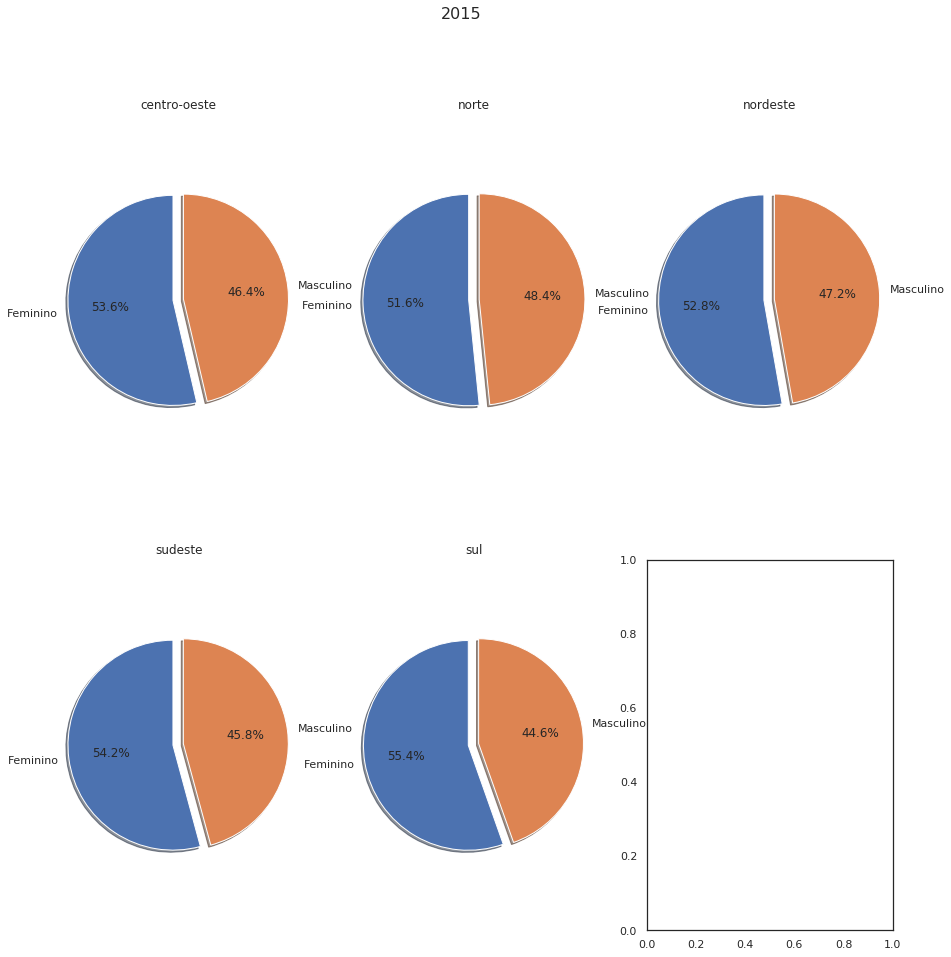

In [39]:
#plot_pie_graph_regions(out_per_region_mais_60_dead['2015'], "VACINA", ("SIM", "NAO"), title="2015")
plot_pie_graph_regions(out_per_region_mais_60_dead['2018'], "CS_SEXO", title="2015")

#plot_histogram_regions(out_per_region_mais_60_infect['2015'], title="2015")

#comm = list(out_per_region_mais_60_infect['2015']['centro-oeste']["COMORBIDADES"])[9]

#print(comm)

#print(extract_important_commobities(comm))


####fazer um grafico de pizza global (26/04) !!!!!!!!!!!


In [40]:
#def extract_high_corr(opt):
#    for i in otp.keys():
#        v = otp[i]
#        for j in v.keys():
#            u = v[j]
#            for k in u.keys():
#                w = u[k].corr()
#                for l in w:
#                    ll = w[l]
#                    for m in ll:
#                        if (m != 1.0 and m > 0.4):
#                            #print(f"{i}-{j}-{k}-{l}:{m}") 
#                            if (l == "VACINA"):
#                                continue
#                                #print(w)
#                                #print("\n")
                